In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tabulate

In [ ]:
!pip install torchnet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29728 sha256=0d93d35744734d7bd7e6174484b7d009f03de5d601a9a086312b5d248b130e50
  Stored in directory: /root/.cache/pip/wheels/f7/ae/94/9f5edd6871983f30967ad11d60ef434c3d1b007654de4c8065
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408194 sha256=8ae357268099216933cefb602f2c64df7cc4a6767daa90fb4ab4ccf64404de19
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built torchnet visdom


In [ ]:
import copy
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tabulate
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchnet.meter as meter
import torchvision

from __future__ import print_function, division
from shutil import copyfile
from sklearn.metrics import f1_score
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from IPython.display import HTML, display

In [ ]:
%matplotlib inline
plt.ion()  # interactive mode

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
data_dir = '/content/drive/MyDrive/Data'
num_classes = 5
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_sizes = {'resnet': 224, 'densenet': 224, 'inception': 299}

In [ ]:
model_name = 'densenet'  # one of 'densenet', 'resnet', or 'inception'
training_style = 'ffe'   # 'ffe' for fixed feature extraction, 'ft' for fine-tuning

In [ ]:
models_dir = 'classify_models'
try: os.makedirs(models_dir)
except OSError: pass

# Path to save trained model
model_path = os.path.join(models_dir, model_name + '_' + training_style + '.pth')
use_model_path = True  # Set to False if model does not exist or if training from scratch

In [ ]:
def get_transform(model_name):
    transform = transforms.Compose([
        transforms.Resize(image_sizes[model_name]),
        transforms.CenterCrop(image_sizes[model_name]),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    return transform

In [ ]:
dataset = datasets.ImageFolder(data_dir, transform=get_transform(model_name))

In [ ]:
def create_samplers(train_percent=0.8):
    random.seed(0)
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    train_split = int(train_percent * len(indices))
    dev_percent = (1 - train_percent) / 2
    dev_split = int((train_percent + dev_percent) * len(indices))
    train_indices = indices[:train_split]
    dev_indices = indices[train_split:dev_split]
    test_indices = indices[dev_split:]

    samplers = {
        'train': torch.utils.data.SubsetRandomSampler(train_indices),
        'dev': torch.utils.data.SubsetRandomSampler(dev_indices),
        'test': torch.utils.data.SubsetRandomSampler(test_indices)
    }
    return samplers

In [ ]:
samplers = create_samplers()
dataloaders = {x: torch.utils.data.DataLoader(dataset, batch_size=4, sampler=samplers[x], num_workers=4)
               for x in ['train', 'dev', 'test']}
dataset_sizes = {x: len(samplers[x]) for x in ['train', 'dev', 'test']}
class_names = dataset.classes

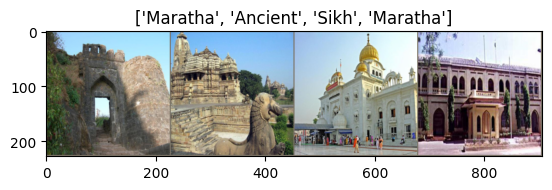

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# Handle fixed feature extraction
def handle_ffe(model):
    if training_style == 'ffe':
        for param in model.parameters():
            param.requires_grad = False
    return model

In [ ]:
def create_model():
    model = None
    if model_name == 'densenet':
        model = handle_ffe(models.densenet201(pretrained=True))
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    # elif model_name == 'resnet':
    #     model = handle_ffe(models.resnet152(pretrained=True))
    #     num_ftrs = model.fc.in_features
    #     model.fc = nn.Linear(num_ftrs, num_classes)
    # elif model_name == 'inception':
    #     model = handle_ffe(models.inception_v3(pretrained=True))
    #     num_aux_ftrs = model.AuxLogits.fc.in_features
    #     model.AuxLogits.fc = nn.Linear(num_aux_ftrs, num_classes)
    #     num_ftrs = model.fc.in_features
    #     model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    return model

In [ ]:
model = create_model()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients.
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if isinstance(outputs, tuple):
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                y_true.extend([class_names[x] for x in labels.data])
                y_pred.extend([class_names[x] for x in preds])

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1_macro = f1_score(y_true, y_pred, labels=class_names, average='macro')
            epoch_f1_per_class = f1_score(y_true, y_pred, labels=class_names, average=None)
            epoch_f1_per_class = ['{:4f}'.format(x) for x in epoch_f1_per_class]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            print('Macro F1 Score: {:4f}'.format(epoch_f1_macro))
            print('F1 Score by Class:')
            display(HTML(tabulate.tabulate([class_names, epoch_f1_per_class], tablefmt='html')))

            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best dev Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
if use_model_path is False or not os.path.exists(model_path):  # Train
    optimizer = optim.Adam(model.parameters())
    train_model(model, nn.CrossEntropyLoss(), optimizer,
                lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1))
    torch.save(model.state_dict(), model_path)
else:  # Load pre-existing model
    model.load_state_dict(torch.load(model_path))
    print('Loaded pre-existing model')

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.war

train Loss: 1.5574 Acc: 0.3547
Macro F1 Score: 0.354483
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.338462,0.369427,0.329268,0.335260,0.400000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 1.0652 Acc: 0.6545
Macro F1 Score: 0.637895
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.600000,0.727273,0.352941,0.592593,0.916667



Epoch 1/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 1.0498 Acc: 0.6339
Macro F1 Score: 0.631960
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.648352,0.625000,0.546584,0.601227,0.738636


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.8342 Acc: 0.7636
Macro F1 Score: 0.736277
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.533333,0.800000,0.888889,0.631579,0.827586



Epoch 2/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.9738 Acc: 0.6682
Macro F1 Score: 0.667668
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.652174,0.691892,0.587571,0.594937,0.811765


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.7002 Acc: 0.7636
Macro F1 Score: 0.739181
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.533333,0.842105,0.800000,0.631579,0.888889



Epoch 3/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.8883 Acc: 0.6888
Macro F1 Score: 0.686713
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.720430,0.714286,0.674699,0.580247,0.743902


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.6282 Acc: 0.8000
Macro F1 Score: 0.795230
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.769231,0.761905,0.782609,0.705882,0.956522



Epoch 4/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.8338 Acc: 0.6934
Macro F1 Score: 0.691899
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.713514,0.662921,0.682353,0.666667,0.734043


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.5821 Acc: 0.8182
Macro F1 Score: 0.810264
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.705882,0.857143,0.869565,0.695652,0.923077



Epoch 5/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.8553 Acc: 0.6773
Macro F1 Score: 0.674370
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.714286,0.694737,0.635294,0.573248,0.754286


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.5145 Acc: 0.8545
Macro F1 Score: 0.854045
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.857143,0.888889,0.774194,0.750000,1.000000



Epoch 6/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6603 Acc: 0.7757
Macro F1 Score: 0.772907
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.831461,0.724324,0.761364,0.693333,0.854054


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.4866 Acc: 0.8727
Macro F1 Score: 0.871305
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.814815,0.823529,0.818182,0.900000,1.000000



Epoch 7/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6503 Acc: 0.7689
Macro F1 Score: 0.769537
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.781065,0.760417,0.743169,0.731707,0.831325


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.5069 Acc: 0.8909
Macro F1 Score: 0.889209
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.952381,0.800000,0.880000,0.857143,0.956522



Epoch 8/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6640 Acc: 0.7712
Macro F1 Score: 0.770012
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.739130,0.778947,0.793103,0.696774,0.842105


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.5833 Acc: 0.8000
Macro F1 Score: 0.789195
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.777778,0.727273,0.846154,0.705882,0.888889



Epoch 9/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6610 Acc: 0.7689
Macro F1 Score: 0.768257
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.795580,0.735135,0.760234,0.716049,0.834286


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.5150 Acc: 0.8727
Macro F1 Score: 0.873540
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.869565,0.888889,0.785714,0.823529,1.000000



Epoch 10/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6709 Acc: 0.7803
Macro F1 Score: 0.780827
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.756757,0.769231,0.795455,0.727273,0.855422


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.5089 Acc: 0.8727
Macro F1 Score: 0.871384
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.900000,0.842105,0.814815,0.800000,1.000000



Epoch 11/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6747 Acc: 0.7620
Macro F1 Score: 0.760085
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.772487,0.785340,0.760234,0.701299,0.781065


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.4713 Acc: 0.9091
Macro F1 Score: 0.905096
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.952381,0.842105,0.888889,0.842105,1.000000



Epoch 12/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6270 Acc: 0.8215
Macro F1 Score: 0.821016
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.832370,0.789189,0.827586,0.768293,0.887640


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.4566 Acc: 0.8545
Macro F1 Score: 0.854706
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.800000,0.823529,0.750000,0.900000,1.000000



Epoch 13/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6218 Acc: 0.7895
Macro F1 Score: 0.788183
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.795918,0.760870,0.765714,0.734694,0.883721


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.4894 Acc: 0.8364
Macro F1 Score: 0.824389
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.869565,0.800000,0.785714,0.666667,1.000000



Epoch 14/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6026 Acc: 0.7986
Macro F1 Score: 0.798291
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.776596,0.775956,0.822857,0.738854,0.877193


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.4749 Acc: 0.8364
Macro F1 Score: 0.833097
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.758621,0.823529,0.833333,0.750000,1.000000



Epoch 15/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6661 Acc: 0.7757
Macro F1 Score: 0.775426
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.766839,0.754098,0.752809,0.710526,0.892857


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.5185 Acc: 0.8364
Macro F1 Score: 0.838130
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.833333,0.761905,0.750000,0.888889,0.956522



Epoch 16/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6166 Acc: 0.7963
Macro F1 Score: 0.796350
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.780749,0.808290,0.770115,0.779221,0.843373


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.4900 Acc: 0.8545
Macro F1 Score: 0.850290
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.909091,0.761905,0.846154,0.777778,0.956522



Epoch 17/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5899 Acc: 0.8238
Macro F1 Score: 0.823402
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.819672,0.818653,0.825581,0.772152,0.880952


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.4957 Acc: 0.8545
Macro F1 Score: 0.848656
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.909091,0.800000,0.833333,0.777778,0.923077



Epoch 18/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6314 Acc: 0.7872
Macro F1 Score: 0.786292
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.744681,0.800000,0.777143,0.716981,0.892655


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.4933 Acc: 0.8727
Macro F1 Score: 0.870239
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.909091,0.800000,0.800000,0.842105,1.000000



Epoch 19/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6437 Acc: 0.7941
Macro F1 Score: 0.793664
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.780220,0.791444,0.793103,0.754717,0.848837


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.4639 Acc: 0.8727
Macro F1 Score: 0.871749
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.880000,0.800000,0.833333,0.888889,0.956522



Epoch 20/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5811 Acc: 0.8124
Macro F1 Score: 0.809940
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.816754,0.800000,0.788571,0.724832,0.919540


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.4627 Acc: 0.8727
Macro F1 Score: 0.872169
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.857143,0.888889,0.814815,0.800000,1.000000



Epoch 21/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6004 Acc: 0.8101
Macro F1 Score: 0.809328
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.802083,0.817204,0.781065,0.774194,0.872093


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.4932 Acc: 0.8182
Macro F1 Score: 0.810966
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.833333,0.800000,0.782609,0.750000,0.888889



Epoch 22/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6434 Acc: 0.7826
Macro F1 Score: 0.782994
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.763006,0.753927,0.806630,0.753086,0.838323


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.5358 Acc: 0.8364
Macro F1 Score: 0.827335
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.900000,0.761905,0.880000,0.705882,0.888889



Epoch 23/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6471 Acc: 0.7918
Macro F1 Score: 0.790115
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.814815,0.781250,0.779070,0.733333,0.842105


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.4902 Acc: 0.8545
Macro F1 Score: 0.850033
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.842105,0.761905,0.846154,0.800000,1.000000



Epoch 24/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6300 Acc: 0.7826
Macro F1 Score: 0.781962
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.757895,0.786885,0.766467,0.725000,0.873563


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dev Loss: 0.4651 Acc: 0.9091
Macro F1 Score: 0.908120
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.916667,0.888889,0.846154,0.888889,1.000000



Training complete in 70m 44s
Best dev Acc: 0.909091


In [ ]:
def test_model(model):
    model.eval()
    confusion_matrix = meter.ConfusionMeter(num_classes)
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            y_true.extend([class_names[x] for x in labels.data])
            y_pred.extend([class_names[x] for x in preds])
            confusion_matrix.add(preds, labels.data)

    acc = corrects.double() / dataset_sizes['test']
    f1_macro = f1_score(y_true, y_pred, labels=class_names, average='macro')
    f1_per_class = f1_score(y_true, y_pred, labels=class_names, average=None)
    f1_per_class = ['{:4f}'.format(x) for x in f1_per_class]
    print('Test Acc: {:4f}'.format(acc))
    print('Macro F1 Score: {:4f}'.format(f1_macro))
    print('F1 Score by Class:')
    display(HTML(tabulate.tabulate([class_names, f1_per_class], tablefmt='html')))
    return model, confusion_matrix.value()

In [ ]:
model, confusion_matrix = test_model(model)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Acc: 0.818182
Macro F1 Score: 0.809835
F1 Score by Class:


Ancient,British,IndoIslamic,Maratha,Sikh
0.833333,0.842105,0.818182,0.666667,0.888889


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


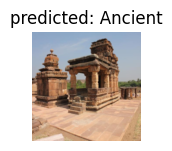

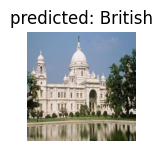

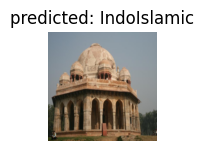

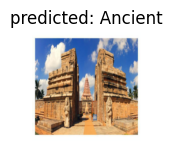

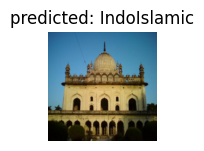

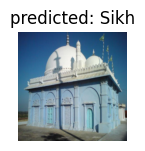

In [ ]:
visualize_model(model)

In [ ]:
def visualize_confusion_matrix(confusion_matrix):
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(16, 12))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    thresh = confusion_matrix.max() / 2
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

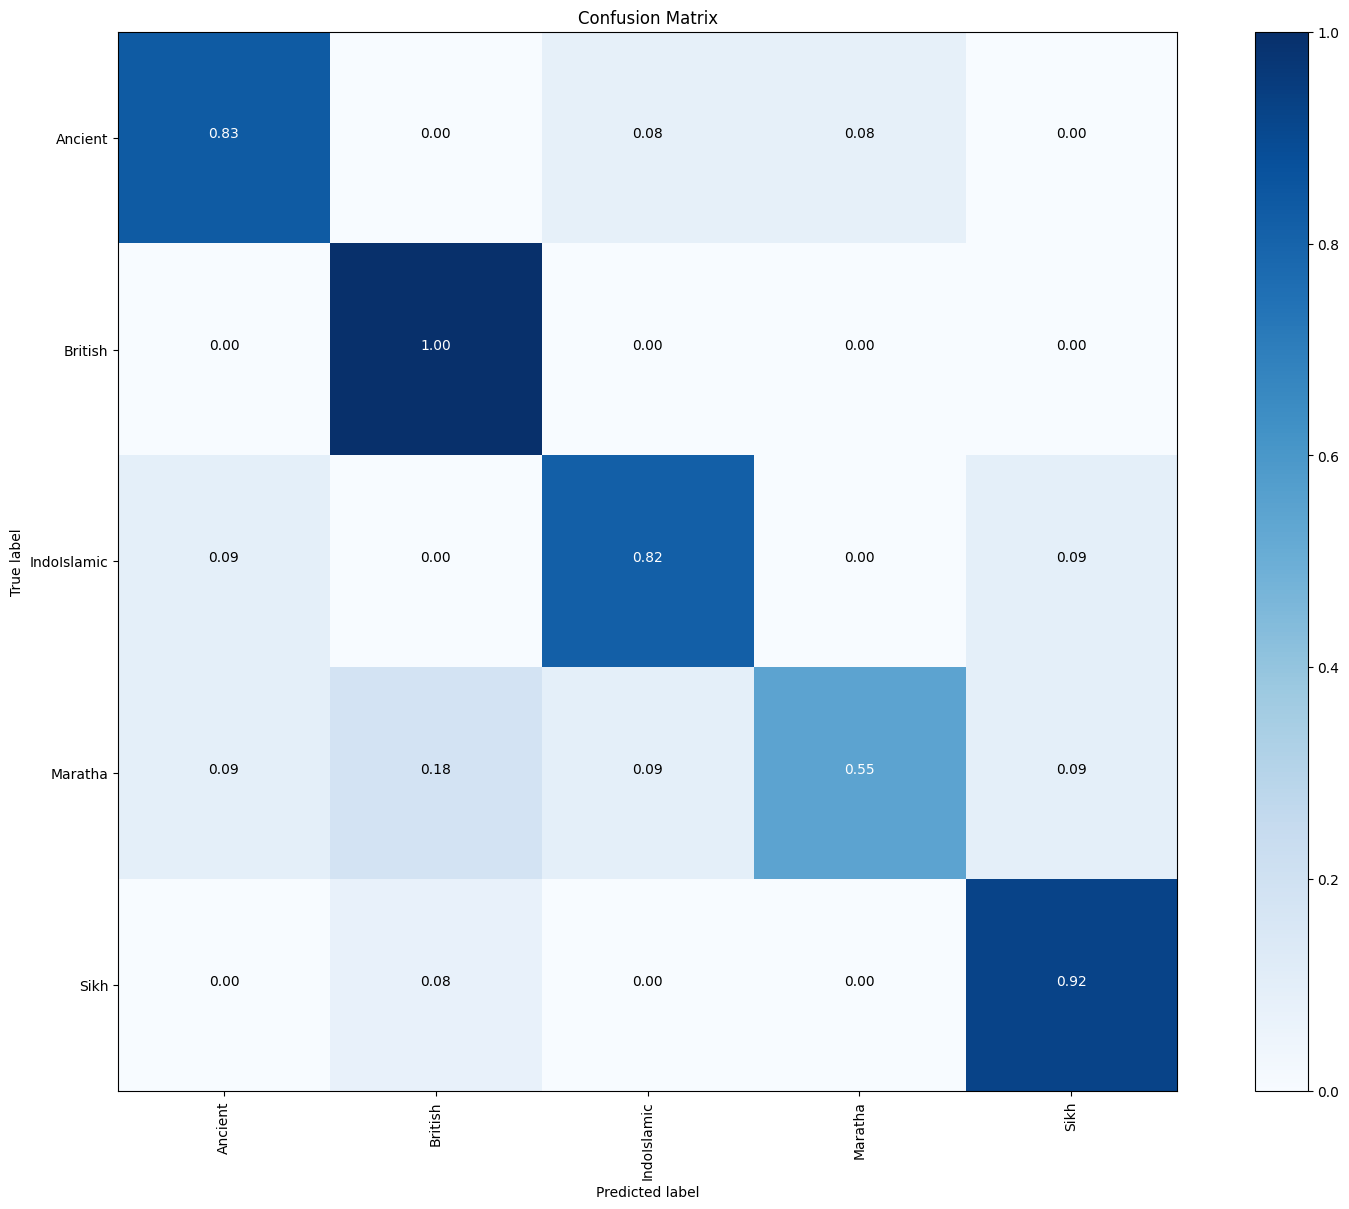

In [ ]:
visualize_confusion_matrix(confusion_matrix)